# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Nguyễn Thị Minh Minh
- MSSV: 21127528
- Lớp: 21CLC10

# Import

In [356]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Đọc dữ liệu

In [357]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng cách khác nếu cần

# Cài đặt hàm

In [358]:
# Cài đặt các hàm cần thiết ở đây
def preprocess(X_train, y_train):
    X = np.hstack((np.ones((X_train.shape[0],1)), X_train))
    return X, y_train

def mae(y, y_pred):
    return np.mean(np.abs(y.ravel() - y_pred.ravel()))

class OLinearRegression:
    def fit(self, X_train, y_train):
        X_pinv = np.linalg.inv(X_train.T @ X_train) @ X_train.T
        self.w = X_pinv @ y_train
        return self
    
    def getParams(self):
        return np.round(self.w, 3)
    
    def predict(self, X):
        return np.sum(self.w.ravel()*X, axis =1)

# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [359]:
# Phần code cho yêu cầu 1a
X1a_train = X_train.iloc[:,0:11]
y1a_train = y_train.to_numpy()
X1a, y1a = preprocess(X1a_train, y1a_train)
lr_1a = OLinearRegression().fit(X1a, y1a)
lr_1a.getParams()


array([ 49248.09 , -23183.33 ,    702.767,   1259.019, -99570.608,
        18369.962,   1297.532,  -8836.727,    141.76 ,    145.742,
          114.643,  34955.75 ])

In [360]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra

X1a_test, y1a_test = preprocess(X_test.iloc[:,0:11], y_test)
y_predict = lr_1a.predict(X1a_test)

MAE_1a = np.round(mae(y1a_test, y_predict),3)
print("Mae = ", MAE_1a)

Mae =  105052.53


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 49248.09 - 23183.33\cdot\text{Gender} + 702.767\cdot\text{10percentage} + 1259.019\cdot\text{12percentage} - 99570.608\cdot\text{CollegeTier} + 18369.962\cdot\text{Degree} + 1297.532\cdot\text{collegeGPA} - 8836.727\cdot\text{CollegeCityTier} + 141.76\cdot\text{English} + 145.742\cdot\text{Logical} + 114.643\cdot\text{Quant} + 34955.75\cdot\text{Domain}$$

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [361]:
def calculate_feature_mae(X_train, y_train, k_fold, feature_dict={'feature': None, 'mae': None}):
    result_dict = {'Feature': feature_dict['feature'], 'MAE': [0] * len(feature_dict['feature'])}
    subsamples = KFold(n_splits=k_fold, shuffle=True).split(X_train)
    length = len(feature_dict['feature'])
    
    for train_index, test_index in subsamples:
        Feature_train, Feature_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        salary_train, salary_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        salary_train = salary_train.values.reshape(-1, 1)
        salary_test = salary_test.values.reshape(-1, 1)
        
        for i in range(length):
            model = LinearRegression()
            col = feature_dict['feature'][i]
            training_set = Feature_train[[col]]
            testing_set = Feature_test[[col]]
            model.fit(training_set, salary_train)
            salary_pred = model.predict(testing_set)
            result_dict['MAE'][i] += mean_absolute_error(salary_test, salary_pred)
    
    # Divide MAE values by k_fold to get average MAE
    result_dict['MAE'] = [np.round(mae / k_fold,3) for mae in result_dict['MAE']]
    
    return pd.DataFrame(result_dict)


In [362]:
# Phần code cho yêu cầu 1b
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu
Feature_1b = {'feature': ['conscientiousness', 'agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience'],
'mae': [0]*5}
result1b_df = calculate_feature_mae(X_train, y_train, 5, Feature_1b)
result1b_df.sort_values(by=['MAE'], inplace=True)
result1b_df.reset_index(drop=True, inplace=True)
result1b_df

,Feature,MAE
0,nueroticism,123503.988000
1,agreeableness,123575.744000
2,openess_to_experience,123804.166000
3,extraversion,123866.071000
4,conscientiousness,124086.188000


In [363]:
print("The best feature: ", result1b_df.iloc[0, 0])

The best feature:  nueroticism


In this problem, Neuroticism and Agreeableness sometimes will swap to achieve the top position. However, the frequency Agreeableness being the best feature is much lower than Neuroticism. **Therefore, I decide to choose Neuroticism becoming the best feature** 

In [364]:
# Huấn luyện lại mô hình best_personality_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
bestFeature_1b = result1b_df.iloc[0,0]
best_Xtrain1b = X_train[bestFeature_1b].values.reshape(-1,1)
best_ytrain1b = y_train.values.reshape(-1,1)
bestFeature_model = LinearRegression().fit(best_Xtrain1b, best_ytrain1b)

coef_1b = np.round(bestFeature_model.coef_,3)
intercept_1b = np.round(bestFeature_model.intercept_,3)
print ("Salary = ", coef_1b[0], "* ", bestFeature_1b, " + ", intercept_1b[0])

Salary =  [-16021.494] *  nueroticism  +  304647.553


In [365]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
best_Xtesting1b = X_test[bestFeature_1b].values.reshape(-1,1)
y_pred1b = bestFeature_model.predict(best_Xtesting1b)
mae1b = np.round(mean_absolute_error(y_test, y_pred1b), 3)
print("MAE of best feature model on test set is ", mae1b)

MAE of best feature model on test set is  119361.917


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -16021.494\cdot\text{nueroticism} + 304647.553$$

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [366]:
# Phần code cho yêu cầu 1c
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu
Feature_1c = {'feature': ['English','Logical','Quant'],
            'mae': [0]*3}
result1c_df = calculate_feature_mae(X_train, y_train, 5, Feature_1c)
result1c_df.sort_values(by=['MAE'], inplace=True)
result1c_df.reset_index(drop=True, inplace=True)
result1c_df

,Feature,MAE
0,Quant,117345.317000
1,Logical,120015.950000
2,English,120762.930000


In [367]:
print("The best feature: ", result1c_df.iloc[0, 0])

The best feature:  Quant


In [368]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
bestFeature_1c = result1c_df.iloc[0,0]
best_Xtrain1c = X_train[bestFeature_1c].values.reshape(-1,1)
best_ytrain1c = y_train.values.reshape(-1,1)
bestFeature_model_1c = LinearRegression().fit(best_Xtrain1c, best_ytrain1c)

coef_1c = np.round(bestFeature_model_1c.coef_,3)
intercept_1c = np.round(bestFeature_model_1c.intercept_,3)
print ("Salary = ", coef_1c[0], "* ", bestFeature_1c, " + ", intercept_1c[0])

Salary =  [368.852] *  Quant  +  117759.729


In [369]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_skill_feature_model
best_Xtesting1c = X_test[bestFeature_1c].values.reshape(-1,1)
y_pred1c = bestFeature_model_1c.predict(best_Xtesting1c)
mae1c = np.round(mean_absolute_error(y_test, y_pred1c), 3)
print("MAE of best feature model on test set is ", mae1c)

MAE of best feature model on test set is  108814.06


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 368.852\cdot\text{Quant} + 117759.729 $$

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

## *MODEL 1*

In [370]:
# Trình bày các phần tìm ra mô hình

#using Pearson Correlation
cor = X_train.corr()
X_train.corr()

,Gender,10percentage,12percentage,CollegeTier,Degree,collegeGPA,CollegeCityTier,English,Logical,Quant,...,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience
Gender,1.000000,0.165208,0.131372,0.028943,-0.007080,0.153008,0.044938,-0.020830,-0.000189,-0.104069,...,-0.031236,-0.083987,-0.024408,0.028421,-0.013109,0.075360,0.087639,0.006984,0.011918,0.084511
10percentage,0.165208,1.000000,0.644518,-0.135469,-0.255081,0.311057,0.106144,0.335863,0.309735,0.326948,...,-0.024749,0.060161,0.068455,0.060164,0.009898,0.050050,0.115473,-0.022176,-0.121777,0.015292
12percentage,0.131372,0.644518,1.000000,-0.092920,-0.227924,0.340745,0.120529,0.193790,0.240047,0.316088,...,-0.050739,0.042870,0.085593,0.057063,0.000678,0.044066,0.093829,-0.031926,-0.083520,-0.007928
CollegeTier,0.028943,-0.135469,-0.092920,1.000000,-0.014755,-0.091280,-0.093067,-0.182399,-0.189068,-0.240973,...,-0.020929,-0.015850,0.012326,-0.010562,0.007080,0.036467,-0.036447,-0.006246,0.038786,-0.019414
Degree,-0.007080,-0.255081,-0.227924,-0.014755,1.000000,0.080067,-0.001511,-0.145472,-0.098722,-0.137183,...,-0.015129,-0.061272,-0.057312,-0.079172,-0.014273,0.003147,-0.033432,0.009707,0.021054,0.014351
collegeGPA,0.153008,0.311057,0.340745,-0.091280,0.080067,1.000000,0.030261,0.099539,0.200165,0.221253,...,-0.013137,-0.033850,0.055134,-0.000657,-0.035964,0.048044,0.053377,-0.054623,-0.074752,0.005078
CollegeCityTier,0.044938,0.106144,0.120529,-0.093067,-0.001511,0.030261,1.000000,0.028303,-0.006065,-0.019965,...,-0.006909,-0.046042,0.016535,0.077937,-0.034213,0.012093,0.009984,0.008211,0.033827,0.015314
English,-0.020830,0.335863,0.193790,-0.182399,-0.145472,0.099539,0.028303,1.000000,0.431918,0.368248,...,0.086161,-0.008649,0.029723,-0.018019,-0.028461,0.024610,0.174948,0.003313,-0.147243,0.061630
Logical,-0.000189,0.309735,0.240047,-0.189068,-0.098722,0.200165,-0.006065,0.431918,1.000000,0.502061,...,0.053090,-0.006461,0.007168,-0.028632,-0.038780,0.007225,0.130697,-0.028864,-0.193569,0.018907
Quant,-0.104069,0.326948,0.316088,-0.240973,-0.137183,0.221253,-0.019965,0.368248,0.502061,1.000000,...,-0.016059,0.002708,0.026210,0.026092,-0.030404,-0.018171,0.077396,-0.065295,-0.145108,-0.009126


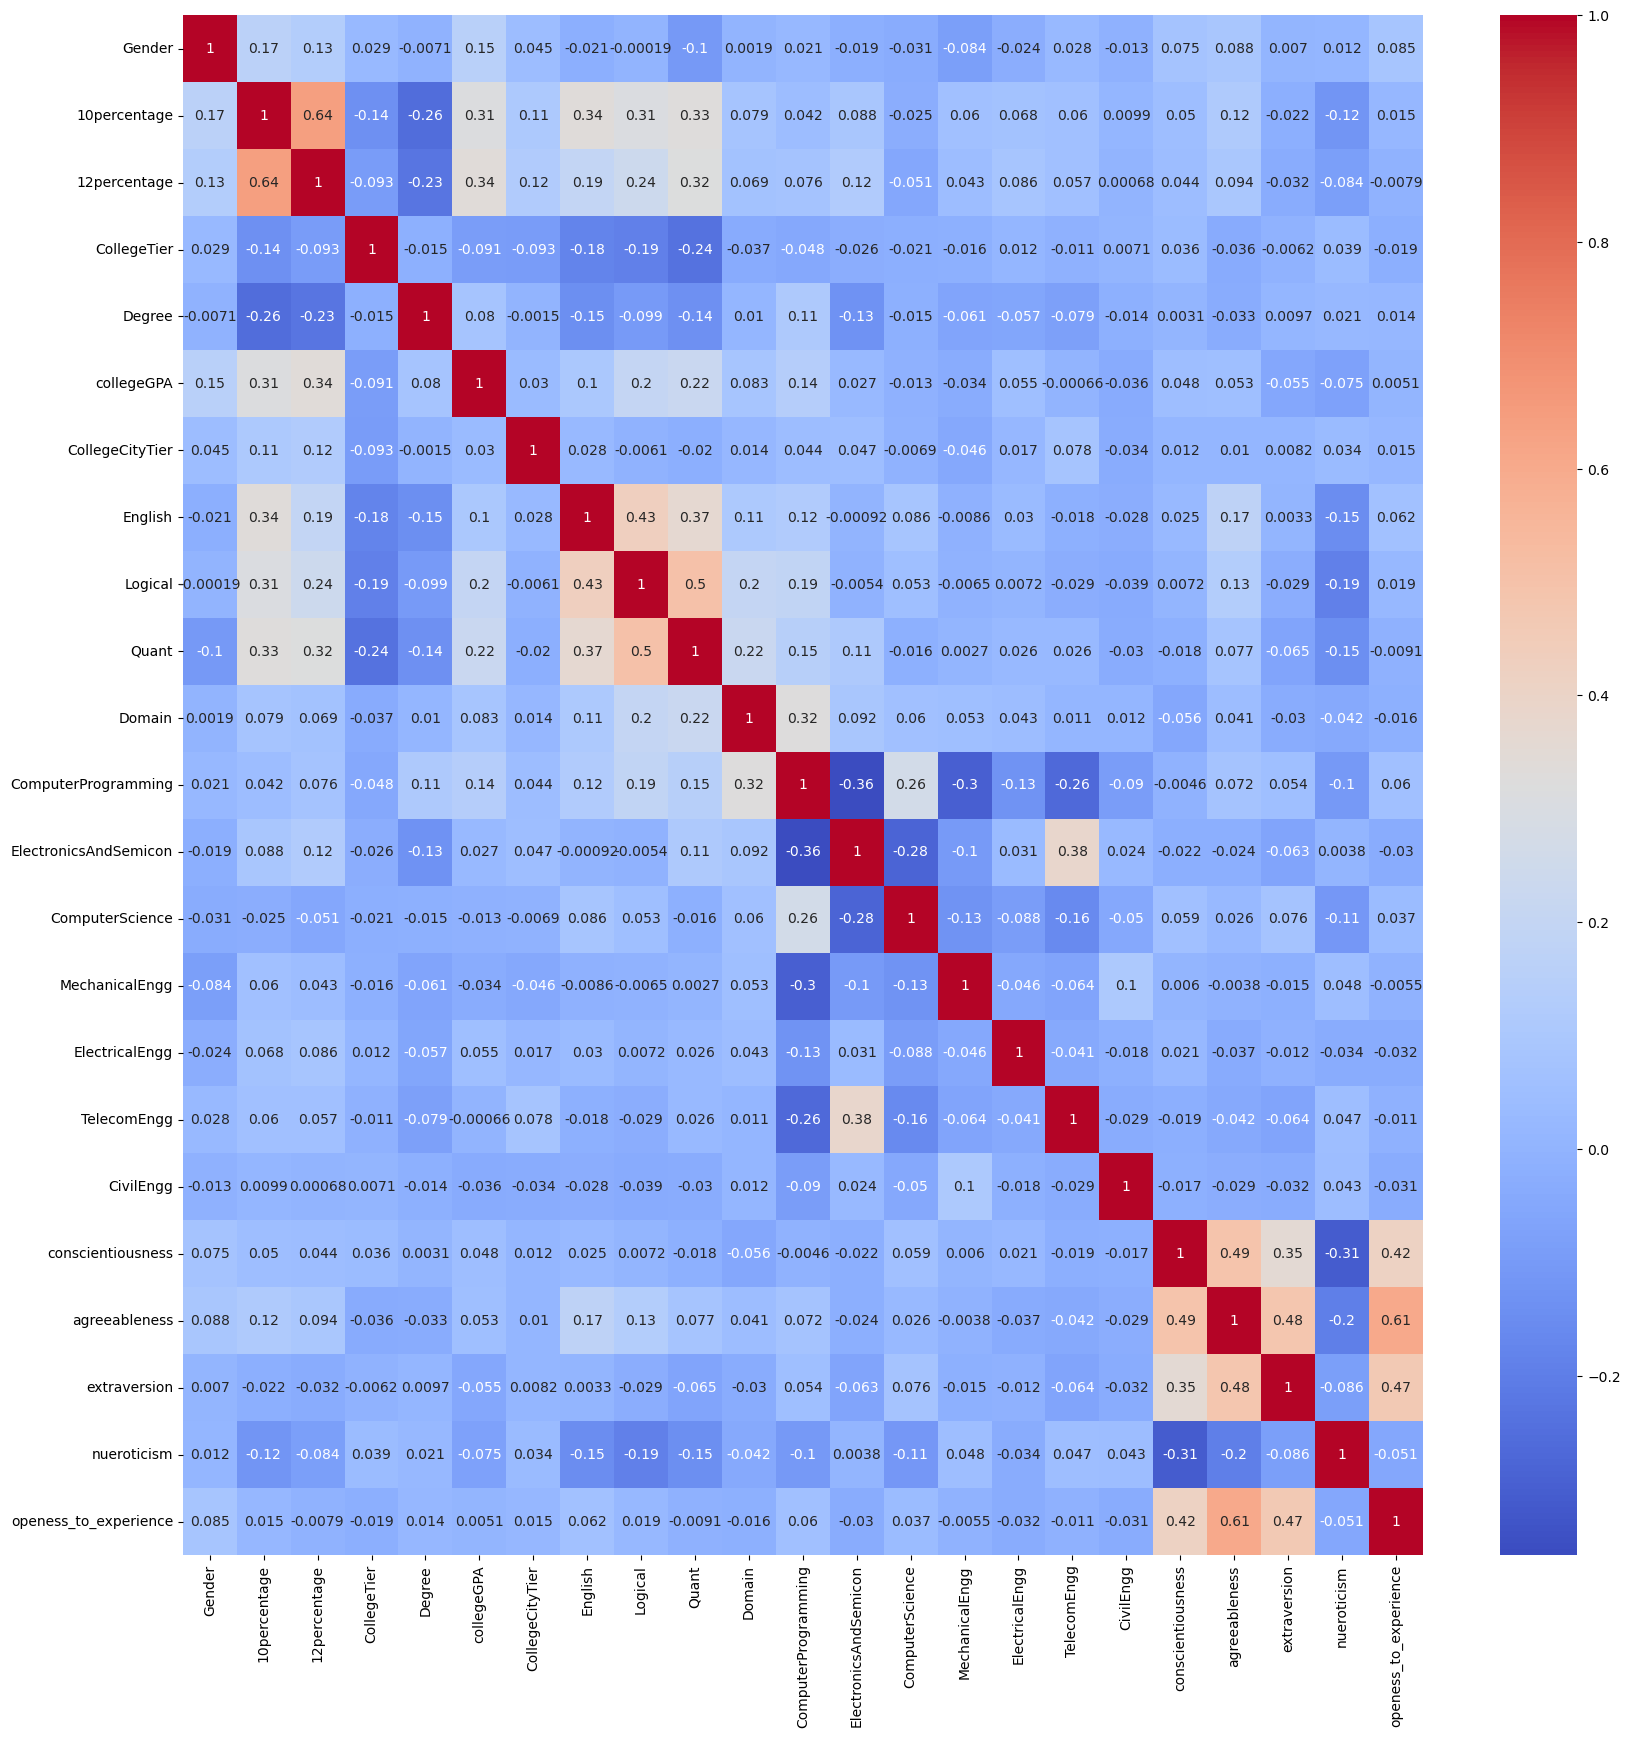

In [371]:
plt.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

In [372]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    len_features = len(corr_matrix.columns)
    for i in range(len_features):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                feature = corr_matrix.columns[i]
                col_corr.add(feature)
    return col_corr

cor_feature2 = correlation2(X_train, 0.45)
cor_feature2

{'12percentage',
 'Quant',
 'agreeableness',
 'extraversion',
 'openess_to_experience'}

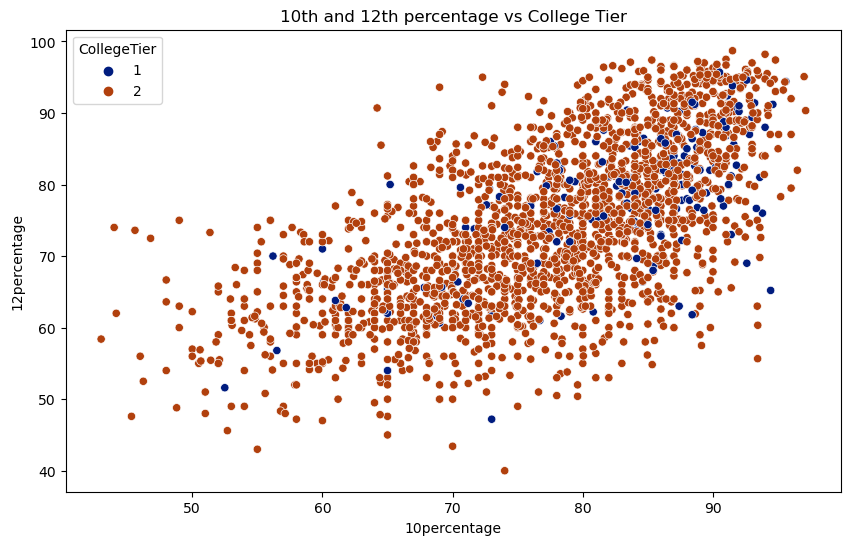

In [373]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='10percentage', y ='12percentage', hue='CollegeTier', palette='dark', data=train)
plt.title('10th and 12th percentage vs College Tier')
plt.show()

From the above model, I can see that two features known as **12percentage** and **10percentage** are positive correlated. This is called multicollinearity, so I decide to drop one **10percentage** and keep **12percentage** feature.

**MODEL 1**: LinearRegression with 5 features: 
* 12percentage
* Quant
* agreeableness
* extraversion
* openess_to_experience

## *MODEL 2*

In [374]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info

array([3.14879394e-05, 8.20288533e-02, 7.34683757e-02, 2.27650186e-02,
       4.05588863e-02, 4.50410072e-02, 0.00000000e+00, 4.81202224e-02,
       5.76777139e-02, 6.86340321e-02, 4.32992270e-02, 2.45146802e-02,
       3.27214944e-02, 4.63407746e-02, 3.09723303e-03, 3.59180049e-03,
       1.61764667e-02, 0.00000000e+00, 4.28844180e-02, 6.01897932e-02,
       5.51085120e-02, 2.23703259e-02, 5.07694966e-02])

In [375]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

10percentage            0.082029
12percentage            0.073468
Quant                   0.068634
agreeableness           0.060190
Logical                 0.057678
extraversion            0.055109
openess_to_experience   0.050769
English                 0.048120
ComputerScience         0.046341
collegeGPA              0.045041
Domain                  0.043299
conscientiousness       0.042884
Degree                  0.040559
ElectronicsAndSemicon   0.032721
ComputerProgramming     0.024515
CollegeTier             0.022765
nueroticism             0.022370
TelecomEngg             0.016176
ElectricalEngg          0.003592
MechanicalEngg          0.003097
Gender                  0.000031
CivilEngg               0.000000
CollegeCityTier         0.000000
dtype: float64

<Axes: >

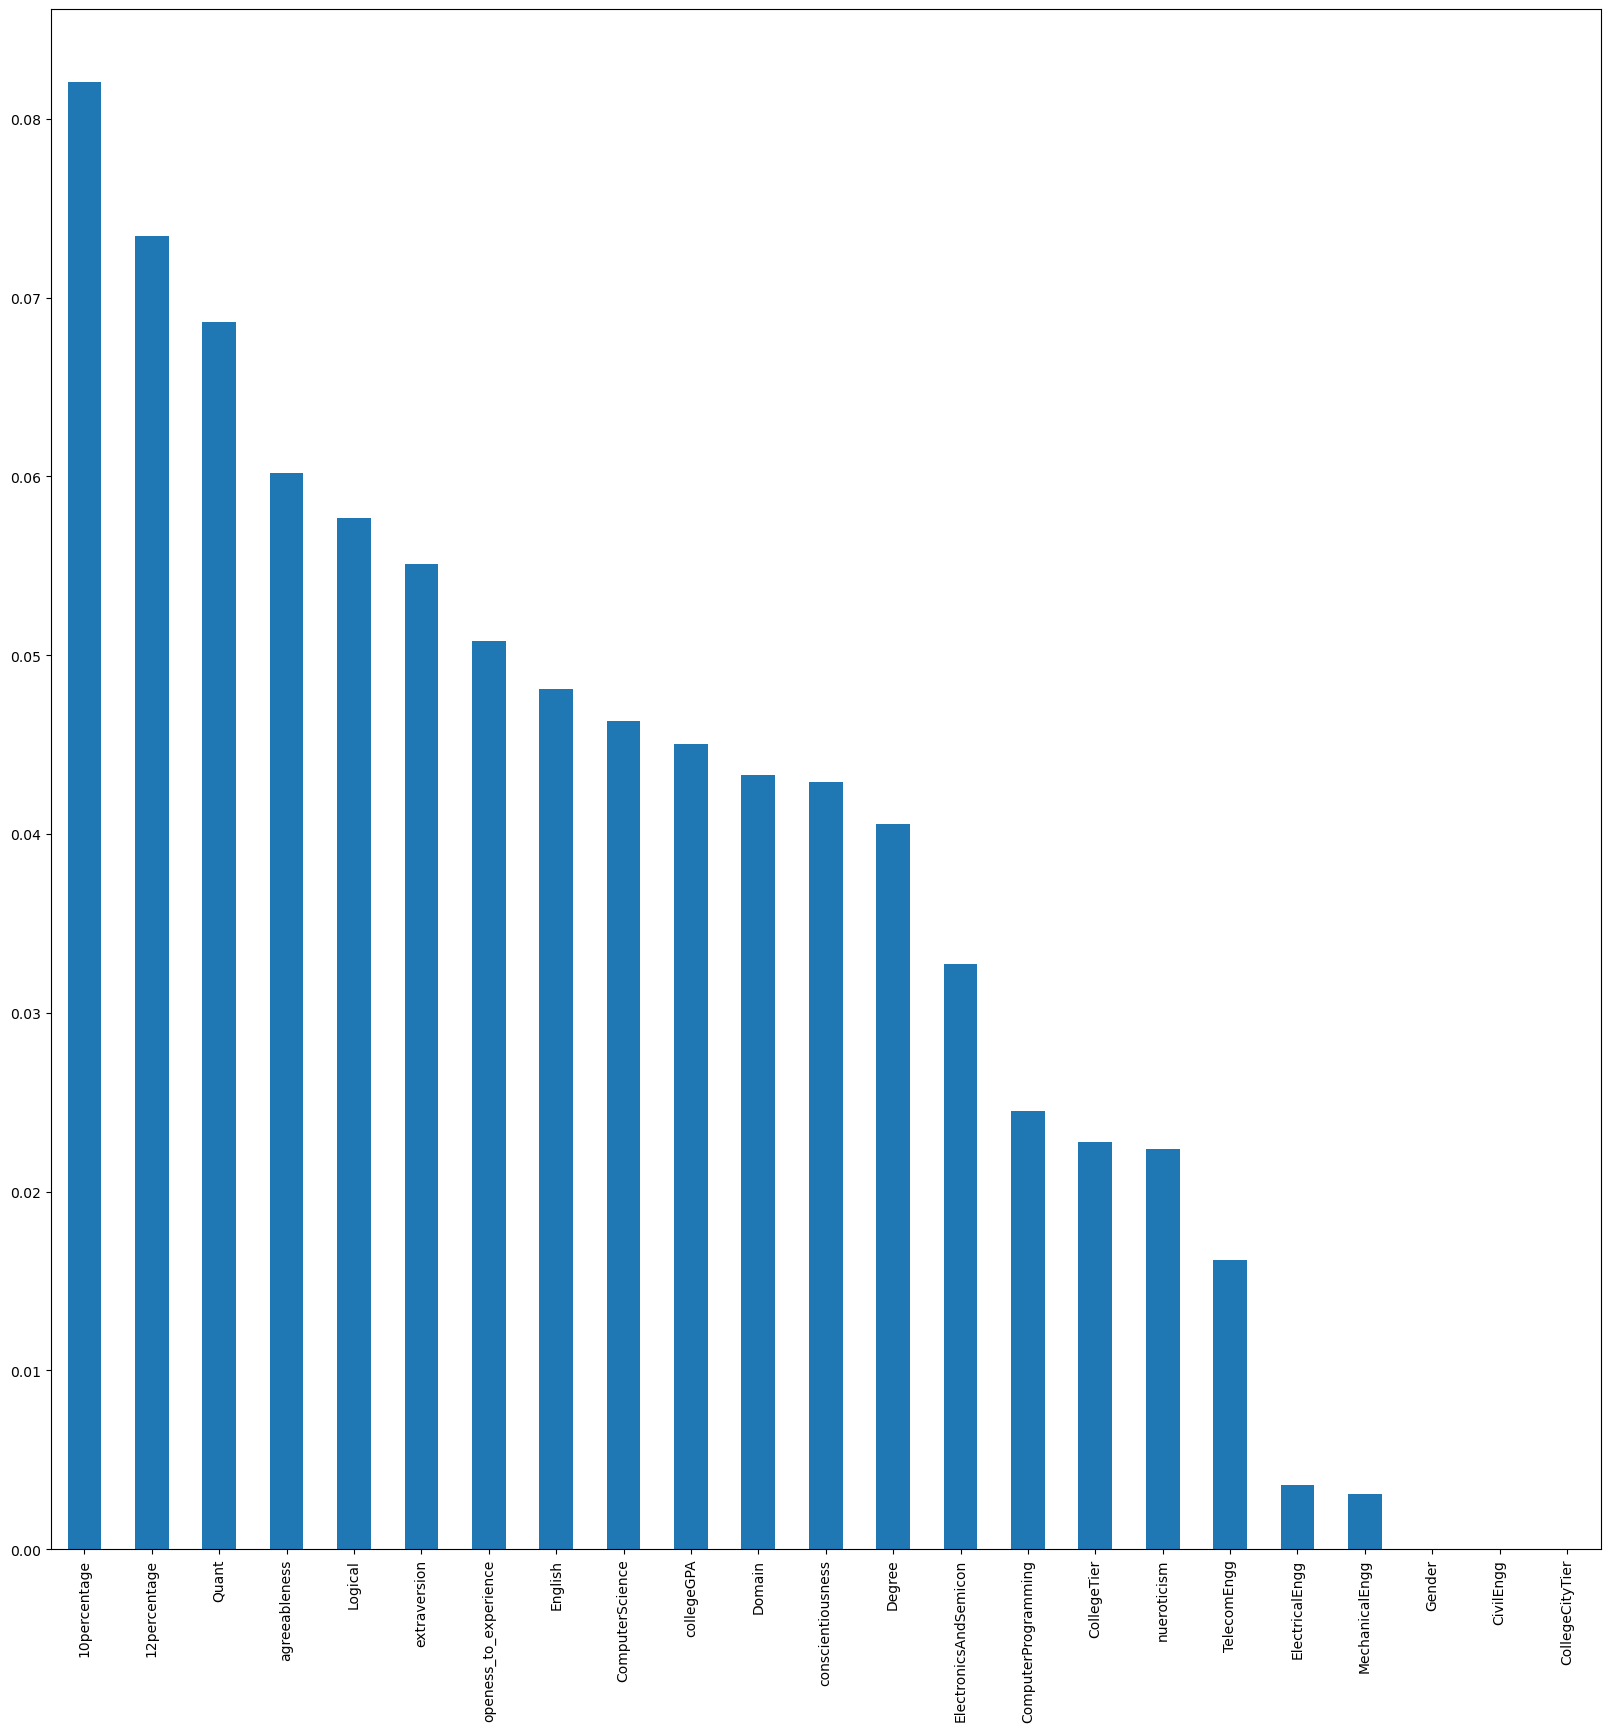

In [376]:
mutual_info.sort_values(ascending=False).plot.bar(figsize = (20,20))

In [377]:
#Selecting top 50%
select_top = SelectPercentile(mutual_info_regression, percentile=50)
select_top.fit(X_train.fillna(0), y_train)
X_train.columns[select_top.get_support()]



Index(['10percentage', '12percentage', 'collegeGPA', 'English', 'Logical',
       'Quant', 'Domain', 'ComputerProgramming', 'ComputerScience',
       'extraversion', 'openess_to_experience'],
      dtype='object')

**MODEL 2**: From the data figure, it is easy to see that half of the features on the left side have significant impact on the range of salary. Therefore, I decide to choose the top 50% to consider as features for my Linear Regression model. 11 features for model:
* 10percentage
* 12percentage
* collegeGPA
* English
* Logical
* Quant
* Domain
* ComputerProgramming
* conscientiousness
* extraversion
* openess_to_experience

## *MODEL 3*

https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1094&context=scschcomdis&fbclid=IwAR0joRSmZEJq2j9SefTP7nDUSduBIAreOu1e8UHVnzDtVJEJblZtelAd0Qc\
This is the link of the paper study I will base on to choose my top features being suitable for my data fitting.

Basically, I will devide the total data set into 4 aspects: 
- Academic Variables: 10percentage, 12percentage and collegeGPA
- Cognitive Skills: English, Logical and Quant
- Standardlized Test Scores: openess_to_experience, neuroticism, extraversion, aggreeable, conscientiousness and domain.
- Specialization: ComputerProgramming, ElectronicsAndSemicon, ComputerScience, MechanicalEngg, ElectricalEngg, TelecomEngg, CivilEngg.

### Gender vs Salary 

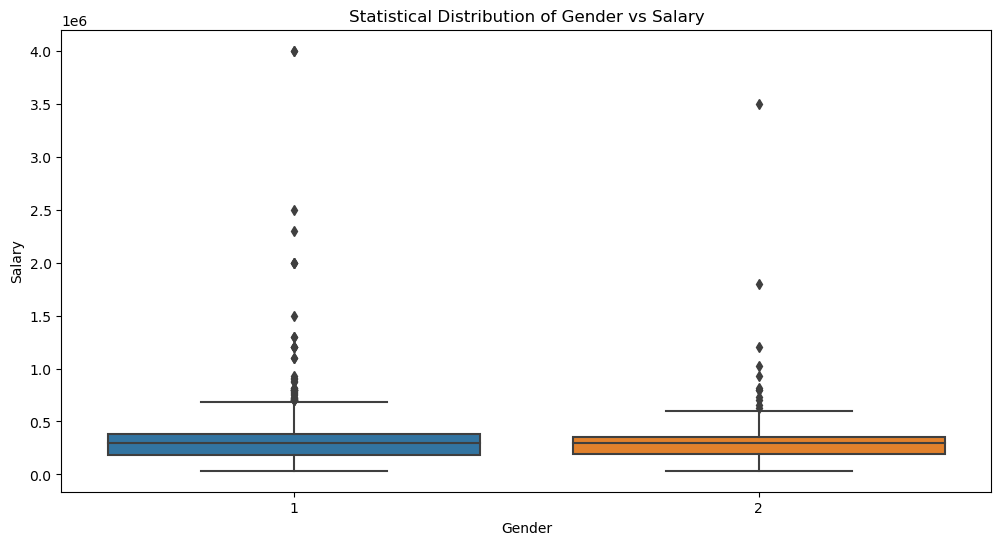

In [378]:
plt.figure(figsize=(12,6))
sns.boxplot( x=train['Gender'], y=train['Salary'] )

plt.title('Statistical Distribution of Gender vs Salary')
plt.show()

From the above figure, I can easily make out that in spite of gender, the salary is quite equivalent. Therefore, this feature will be dropped.

### Academic Variables

<Axes: >

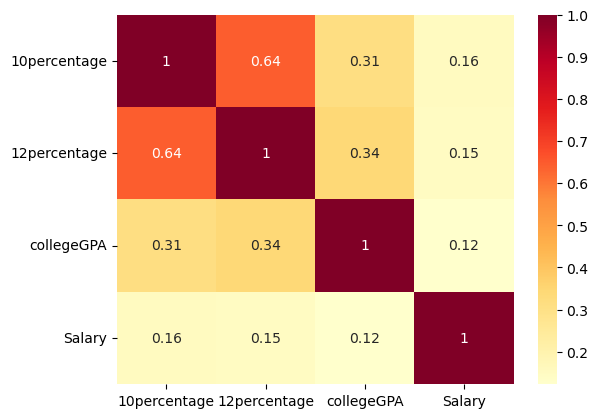

In [379]:
academic_variable = ["10percentage","12percentage","collegeGPA","Salary"]
academic_set = train[academic_variable]
sns.heatmap(academic_set.corr(), annot=True, cmap='YlOrRd')

Overall, the correlation between salary and other features is quite weak. However, correlation among features in group of Academic variable is quite good. Therefore, all forementioned 3 features are still significant contributors predicting the salary as changes in one academic-related feature could provide insight into how the other related feature might change, thus affecting the salary prediction.\
**All 3 features are chosen: *10percentage*, *12percentage*, *collegeGPA***

### Cognitive Skills

In [380]:
X_cognitive = X_train[['English', 'Logical', 'Quant', 'Gender']]
X_cognitive = sm.add_constant(X_cognitive)
y_cognitive = y_train

X_train_cog, X_cognitive, y_train_cog, y_cognitive = train_test_split(X_cognitive, y_cognitive, test_size=0.2, random_state=42)

cognitive_model = sm.OLS(y_train_cog, X_train_cog).fit()

t_statistics_cog = cognitive_model.tvalues
p_values_cog = cognitive_model.pvalues

cognitive_data = pd.DataFrame({'t_statistics': t_statistics_cog, 'p_values': p_values_cog})
cognitive_data

,t_statistics,p_values
const,0.036662,0.970759
English,4.087251,0.000046
Logical,2.998230,0.002753
Quant,5.589068,0.000000
Gender,-1.434303,0.151660


* In this part, with the idea from above reference, I decide to use *t_statistics* and *p_values* to assess the significance in the model.
* The reason why I add *Gender* while assessing the significance of cognitive skills is to set it as control variable. So what is control variable? According to my reference, a control variable is a variable that is included in the analysis to get impact on the relationship among features. In this case, the main features are cognitive skills, and the outcome is salary, control variable is *Gender*. *Gender* helps isolate the result significance on the chosen features then better result is produced; else one of the features in cognitive group could be chosen as the control variables leading to less precise result.
* **Page 49 of *https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1094&context=scschcomdis&fbclid=IwAR0joRSmZEJq2j9SefTP7nDUSduBIAreOu1e8UHVnzDtVJEJblZtelAd0Qc*** 
* **https://takelessons.com/blog/what-is-a-controlled-variable-in-science**

* Gender has *p_value* much greater than the other three features, so drop it.
* In terms of *Logical*, the *t_statistic* show that this feature seems to be insignificant when comparing with *English* and *Quant*. So I decide to drop the feature *Logical*.
* In conclusion, the chosen features in cognitive skills group is **English** and **Quant**.

### Standardlized Test Scores

In [381]:
X_score = X_train[['openess_to_experience', 'nueroticism', 'extraversion','agreeableness','conscientiousness','Domain', 'Gender']]
X_score = sm.add_constant(X_score)
y_score = y_train

X_train_score, X_score, y_train_score, y_score = train_test_split(X_score, y_score, test_size=0.2, random_state=42)

score_model = sm.OLS(y_train_score, X_train_score).fit()

coeff_score = score_model.params
t_value_score = score_model.tvalues

score_data = pd.DataFrame({'Coefficent': coeff_score, 't-statistics': t_value_score})
score_data

,Coefficent,t-statistics
const,306165.180968,19.555044
openess_to_experience,-4615.652079,-0.741127
nueroticism,-17297.466145,-3.484679
extraversion,-207.679140,-0.035428
agreeableness,30066.940077,4.320175
conscientiousness,-24559.937839,-4.276918
Domain,50429.659244,4.939559
Gender,-24852.973730,-2.187159


* From the above statistic feature with coefficients and t-statistics, I can see that clearly *Domain* and *agreeableness* possess highest coefficient and t-statistics. Therefore, the significance and practical impact on the salary of the two features would be the biggest in this group. In the remain features, I still see there is a large gap between the *extraversion* and others, the coefficient and t-statistics of *extraversion* is bigger than other quiet much.
* In conclusion, **Domain**, **agreeableness** and **extraversion** are chosen.

### Specilization

In [382]:
X_special = X_train[['ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience','MechanicalEngg','ElectricalEngg','TelecomEngg', 'CivilEngg', 'Gender']]
X_special = sm.add_constant(X_special)
y_special = y_train

X_train_special, X_special, y_train_special, y_special = train_test_split(X_special, y_special, test_size=0.2, random_state=42)

special_model = sm.OLS(y_train_special, X_train_special).fit()

coeff_special = special_model.params
t_value_special = special_model.tvalues

special_data = pd.DataFrame({'Coefficent': coeff_special, 't-statistics': t_value_special})
special_data

,Coefficent,t-statistics
const,274403.041500,13.976664
ComputerProgramming,203.358886,7.328815
ElectronicsAndSemicon,64.870378,1.822704
ComputerScience,-152.040234,-5.269660
MechanicalEngg,162.049190,3.033134
ElectricalEngg,-90.008686,-1.652380
TelecomEngg,-61.320581,-1.209225
CivilEngg,170.129252,1.170273
Gender,-24391.277193,-2.159362


* Similar explanation with above, in this group, I choose 4 features: **ComputerProgramming**, **ElectronicsAndSemicon**, **MechanicalEngg**, **CivilEngg**

**MODEL 3**: LINEAR REGRESSION WITH 12 FEATURES:
* 10percentage
* 12percentage
* collegeGPA
* English
* Quant
* Domain
* agreeableness
* ComputerProgramming
* ElectronicsAndSemicon
* MechanicalEngg

## Thử nghiệm, so sánh các mô hình

In [383]:
def average_mae(X_train, y_train, k_fold):
    subsamples = KFold(n_splits=k_fold, shuffle=True).split(X_train)
    
    mae = 0
    for train_index, test_index in subsamples:
        X_train_fold, X_test_fold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model = LinearRegression().fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)
        mae += mean_absolute_error(y_test_fold, y_pred)
        
    return np.round(mae / k_fold,3)

In [384]:
# Phần code cho yêu cầu 1d
# Tìm ra mô hình tốt nhất (tự thiết kế bởi sinh viên)
# In ra các kết quả cross-validation như yêu cầu
Model_Dataframe = pd.DataFrame(columns=['Model', 'MAE'])

# MODEL1
model1_feature = ["12percentage", "Quant", "agreeableness", "extraversion", "openess_to_experience"]
train_model1 = X_train[model1_feature]
mae_model1 = average_mae(train_model1, y_train, 5)
Model_Dataframe = pd.concat([Model_Dataframe, pd.DataFrame([{'Model': 'MODEL1', 'MAE': mae_model1}])])

# Model_Dataframe

# MODEL2
model2_feature = ["10percentage", "12percentage", "collegeGPA", "English", "Logical", "Quant", "Domain", "conscientiousness", "extraversion", "nueroticism", "openess_to_experience"]
train_model2 = X_train[model2_feature]
mae_model2 = average_mae(train_model2, y_train, 5)
Model_Dataframe = pd.concat([Model_Dataframe, pd.DataFrame([{'Model': 'MODEL2', 'MAE': mae_model2}])])

# MODEL 3

model3_feature = ["10percentage", "12percentage", "collegeGPA", "English", "Quant", "Domain",  "ComputerProgramming", "ElectronicsAndSemicon", "MechanicalEngg", "CivilEngg", "agreeableness","extraversion"]
train_model3 = X_train[model3_feature]
mae_model3 = average_mae(train_model3, y_train, 5)
Model_Dataframe = pd.concat([Model_Dataframe, pd.DataFrame([{'Model': 'MODEL3', 'MAE': mae_model3}])])
Model_Dataframe.sort_values(by=['MAE'], inplace=True)
Model_Dataframe.reset_index(drop=True, inplace=True)
Model_Dataframe

,Model,MAE
0,MODEL2,113338.602000
1,MODEL3,113803.993000
2,MODEL1,115722.239000


In [385]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện

train_model3 = X_train[model3_feature]
y_model3 = y_train
best_model = LinearRegression().fit(train_model3, y_model3)
coef_model = np.round(best_model.coef_,3)
intercept_model = np.round(best_model.intercept_,3)

formatted_coef = np.array([np.format_float_positional(coef, precision=3, unique=False) for coef in coef_model])
print(formatted_coef)
print(intercept_model)



['692.034' '914.832' '1319.187' '178.172' '204.223' '21464.018' '95.965'
 '0.461' '111.833' '177.135' '7182.855' '-1709.676']
-151323.732


In [386]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
test_model3 = X_test[model3_feature]
y_pred_model = best_model.predict(test_model3)
mae = mean_absolute_error(y_test, y_pred_model)
print(mae)

103764.3752266738


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 692.034\cdot\text{10percentage} + 914.832\cdot\text{12percentage} + 1319.187\cdot\text{collegeGPA} + 178.172\cdot\text{English} + 204.223\cdot\text{Quant} + 21464.018\cdot\text{Domain} + 95.965\cdot\text{ComputerProgramming} + 0.461\cdot\text{ElectronicsAndSemicon} + 111.833\cdot\text{MechanicalEngg} + 177.135\cdot\text{CivilEngg} + 7182.855\cdot\text{agreeableness} - 1709.676\cdot\text{extraversion} - 151323.732$$